In [ ]:
'''

HW1-JINGYI-MA(iris_ma)

'''

## 1) Change the 2 functions in mse_02.py to 2 new functions, and train and test the neural net.##

In [ ]:
# method 1: using self.non_linear = nn.SELU(inplace=False) as activation function

NN(
  (linear0): Linear(in_features=1, out_features=100, bias=True)
  (linear1): Linear(in_features=100, out_features=100, bias=True)
  (out0): Linear(in_features=100, out_features=1, bias=True)
  (out1): Linear(in_features=100, out_features=1, bias=True)
  (non_linear): SELU()
  (dropout): Dropout(p=0.0, inplace=False)
)
epoch =     0     5000 train =     5000	 19.3063   3.6596	dev =      101	  0.8307   0.3103
epoch =     1    10003 train =     5003	  0.4516   0.2135	dev =      101	  0.3353   0.2219
epoch =     2    15006 train =     5003	  0.2051   0.1878	dev =      101	  0.1656   0.2034
epoch =     3    20009 train =     5003	  0.0974   0.1339	dev =      101	  0.0778   0.1290
epoch =     4    25002 train =     4993	  0.0521   0.1045	dev =      101	  0.0348   0.0976
epoch =     5    30005 train =     5003	  0.0235   0.0774	dev =      101	  0.0213   0.0632
epoch =     6    35008 train =     5003	  0.0118   0.0547	dev =      101	  0.0076   0.0545
epoch =     7    40001 train =     4993

D:\anaconda\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type SELU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


time = 14.17 (sec)

mean squared error for test data = 0.005876796202616648


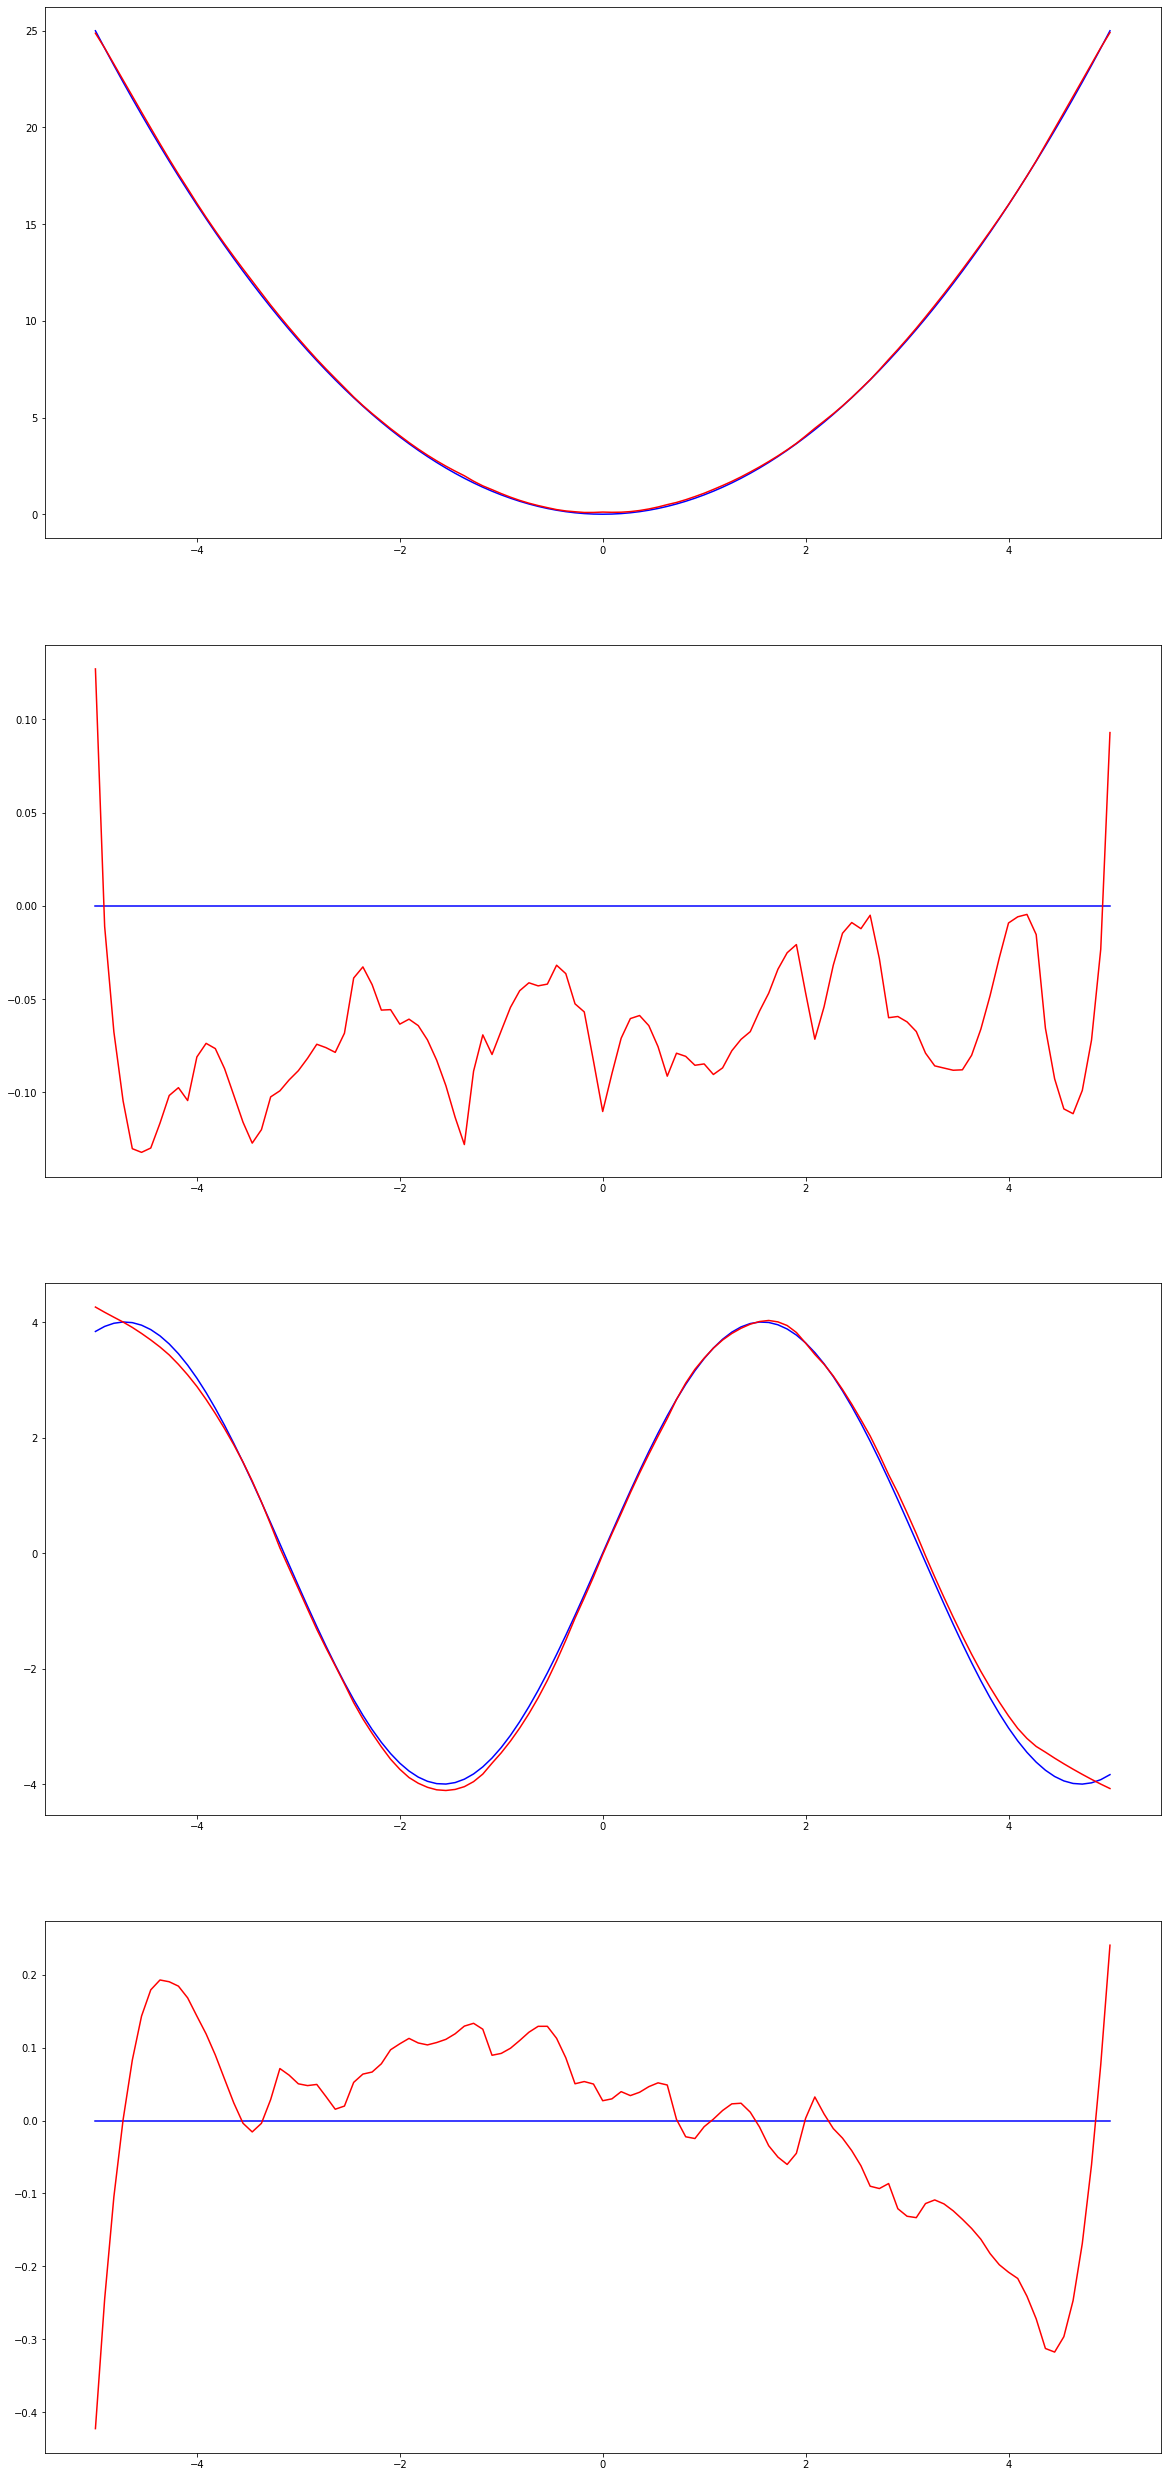

In [4]:
###############################################################################
# PyTorch examples - MSELoss (Mean Squared Error)
###############################################################################
import time
import numpy as np
from random import shuffle
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
#from torch.autograd import Variable

###############################################################################
use_cuda = torch.cuda.is_available()
use_cuda = False

###############################################################################
# hyperparameters
###############################################################################
nLinear1 = 100
nLinear2 = 100

#learning_rate = 0.0001
learning_rate = 0.001
#learning_rate = 0.01
#learning_rate = 0.1

# regularization (dropout, L2, batch size) -- lecture 4
dropout = 0.0
#dropout = 0.1

L2_lambda = 0.0
#L2_lambda = 0.1

#batch_size = 100
batch_size = 10
#batch_size = 1

# control amount of training data
nTrainPoints = 10
#nTrainPoints = 19
#nTrainPoints = 1009
nTrainPoints = 5003

nDevPoints = 101

nTestPoints = 111

#DesiredTrainSamples = 5000
DesiredTrainSamples = 50000

DisplayInterval = 5000

###############################################################################
class NN(nn.Module):
###############################################################################
    def __init__(self, input_size, nLinear1, nLinear2, output_size, dropout=0.0):
        super(NN, self).__init__()
        self.linear0 = nn.Linear(input_size, nLinear1)
        self.linear1 = nn.Linear(nLinear1, nLinear2)

        self.out0 = nn.Linear(nLinear2, 1)    # output for func0
        self.out1 = nn.Linear(nLinear2, 1)    # output for func1

        # all applicable non-linear functions from PyTorch with default parameters
        # pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity
        self.non_linear = nn.SELU(inplace=False)

        self.dropout = nn.Dropout(dropout)

        for p in self.parameters(): # optionally apply different randomization
            if p.dim() > 1:
                # all random initializations from PyTorch with default parameters
                nn.init.constant_(p, val=1.0)   # this is a really bad idea -- don't use it
                nn.init.orthogonal_(p, gain=1)
                nn.init.sparse_(p, sparsity=0.9, std=0.01)

                nn.init.uniform_(p, a=0.0, b=1.0)   # this works poorly, see next
                nn.init.uniform_(p, a=-1.0, b=1.0)  # default is a=0.0, b=1.0
                nn.init.normal_(p, mean=0.0, std=1.0)

                nn.init.kaiming_uniform_(p, a=0, mode='fan_in', nonlinearity='leaky_relu')
                nn.init.kaiming_normal_(p, a=0, mode='fan_in', nonlinearity='leaky_relu')

                nn.init.xavier_uniform_(p)
                nn.init.xavier_normal_(p)

    ###########################################################################
    def forward(self, inputs):
        nPoints = len(inputs)
        x = inputs.view(nPoints, -1)

        x = self.linear0(x)
        x = self.non_linear(x)
        x = self.dropout(x)

        x = self.linear1(x)
        x = self.non_linear(x)
        x = self.dropout(x)

        out0 = self.out0(x)  # func0
        out1 = self.out1(x)  # func1

        return out0, out1

###############################################################################
def train(model, optimizer, criteria, data, idx_list, update=True):
    model.zero_grad()

    nPoints = len(idx_list)
    inputs = []
    targets0 = []
    targets1 = []
    loss0 = 0
    loss1 = 0

    for i in idx_list:
        inputs.append(data[0][i])
        targets0.append(data[1][i])
        targets1.append(data[2][i])

    #inputs  = Variable(torch.Tensor(inputs))   # Variable is no longer needed
    inputs  = torch.Tensor(inputs)
    targets0 = torch.Tensor(targets0)
    targets1 = torch.Tensor(targets1)

    if use_cuda:
        inputs = inputs.cuda()
        targets0 = targets0.cuda()
        targets1 = targets1.cuda()

    output0, output1 = model(inputs)     # "model()" invokes "model.forward()"

    loss0 += criteria[0](output0.view(-1), targets0)
    loss1 += criteria[1](output1.view(-1), targets1)

    if update:
        loss = loss0 + loss1
        loss.backward()
        optimizer.step()

    return loss0.item(), loss1.item(), nPoints

###############################################################################
def train_model(model, train_data, dev_data):
    train_list  = [i for i in range(len(train_data[0]))]    # list of indexes of training data
    dev_list    = [i for i in range(len(dev_data[0]))]      # list of indexes of dev data
    
    criterion0 = nn.MSELoss(reduction='sum')
    criterion1 = nn.MSELoss(reduction='sum')
    criteria = [criterion0, criterion1]

    # choose an optimizer
    # all optimizers from PyTorch with default parameters, except learning_rate, and weight_decay
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=L2_lambda, amsgrad=False)

    ###############################################################################
    # train model 
    ###############################################################################
    start = time.time()

    nEpochs = ((DesiredTrainSamples - 1) // len(train_list)) + 1

    TrainLoss0 = 0
    TrainLoss1 = 0
    TrainPoints = 0
    TotalTrainSamples = 0
    nCurrentSamples = 0

    model.train()
    for epoch in range(nEpochs):
        shuffle(train_list)     # make it a habit to shuffle data, even if random
        #print(train_list)
        for i in range(0, len(train_list), batch_size):
            loss0, loss1, nPoints = train(model, optimizer, criteria, train_data, train_list[i:i+batch_size], update=True)
            #print(i, nTrainPairs, loss / nPoints)
            TrainLoss0 += loss0
            TrainLoss1 += loss1
            TrainPoints += nPoints
            TotalTrainSamples += nPoints
            nCurrentSamples += nPoints

            if (nCurrentSamples >= DisplayInterval) or (TotalTrainSamples >= DesiredTrainSamples):
                model.eval()
                DevLoss0, DevLoss1, DevPoints = train(model, optimizer, criteria, dev_data, dev_list, update=False)
                model.train()
                print("epoch = %5d %8d train = %8d\t%8.4f %8.4f\tdev = %8d\t%8.4f %8.4f" % (epoch, TotalTrainSamples, TrainPoints, TrainLoss0 / TrainPoints, TrainLoss1 / TrainPoints, DevPoints, DevLoss0 / DevPoints, DevLoss1 / DevPoints))

                TrainLoss0 = 0
                TrainLoss1 = 0
                TrainPoints = 0
                nCurrentSamples -= DisplayInterval

            if TotalTrainSamples >= DesiredTrainSamples:
                break

        if TotalTrainSamples >= DesiredTrainSamples:
            break

    torch.save(model, 'mse_02-temp.pth')

    return

###############################################################################
def func0(x):
    y = x*x
    return y

###############################################################################
def func1(x):
    #y = (x+1)*(x-2)
    y = 4*np.sin(x)
    return y

###############################################################################
def create_data(data_spec):
    x_lower, x_upper, nPoints = data_spec
    x = np.linspace(x_lower, x_upper, num=nPoints, endpoint=True).astype(np.float32)
    y0 = func0(x)
    y1 = func1(x)
    return [x, y0, y1]

###############################################################################
if __name__ == "__main__":
    start = time.time()

    ###############################################################################
    # create data
    ###############################################################################
    lower_bound = -5
    upper_bound = +5

    train_data  = create_data([lower_bound, upper_bound, nTrainPoints])
    dev_data    = create_data([lower_bound, upper_bound, nDevPoints])
    test_data   = create_data([lower_bound, upper_bound, nTestPoints])

    ###############################################################################
    # create model 
    ###############################################################################
    model = NN(1, nLinear1, nLinear2, 1, dropout)
    print(model)
    if use_cuda:
        model = model.cuda()

    train_model(model, train_data, dev_data)

    end = time.time()
    elapsed = end - start
    print("time = %.2f (sec)\n" % (elapsed))

    # let's see our neural network in action
    show_results = True
    #show_results = False
    if show_results:
        x, y0, y1 = test_data
        out0, out1 = model(torch.Tensor(x))
        #print(out0)
        out0 = out0.detach().cpu().numpy()[:,0] # remove output values from network, move to cpu, convert to numpy
        out1 = out1.detach().cpu().numpy()[:,0]
        #print(out0)
        #print(out0.shape)
        mse0 = (((y0 - out0)**2).sum()) / len(y0)
        print("mean squared error for test data =", mse0)

        nPlots = 4
        fig = plt.figure(figsize=(20,45))

        plt.subplot(nPlots,1,1)
        plt.plot(x, y0, 'b')
        plt.plot(x, out0, 'r')

        plt.subplot(nPlots,1,2)
        plt.plot(x, y0-y0, 'b')
        plt.plot(x, y0-out0, 'r')
        #plt.plot(train_data[0], train_data[1]-train_data[1], 'o')

        plt.subplot(nPlots,1,3)
        plt.plot(x, y1, 'b')
        plt.plot(x, out1, 'r')

        plt.subplot(nPlots,1,4)
        plt.plot(x, y1-y1, 'b')
        plt.plot(x, y1-out1, 'r')
        #plt.plot(train_data[0], train_data[2]-train_data[2], 'o')

        plt.show()


In [ ]:
#method 2:using self.non_linear = nn.Softshrink(lambd=0.5) as activation function

NN(
  (linear0): Linear(in_features=1, out_features=100, bias=True)
  (linear1): Linear(in_features=100, out_features=100, bias=True)
  (out0): Linear(in_features=100, out_features=1, bias=True)
  (out1): Linear(in_features=100, out_features=1, bias=True)
  (non_linear): Softshrink(0.5)
  (dropout): Dropout(p=0.0, inplace=False)
)
epoch =     0     5000 train =     5000	 16.1872   4.1706	dev =      101	  0.7431   0.5885
epoch =     1    10003 train =     5003	  0.3256   0.2660	dev =      101	  0.1626   0.1356
epoch =     2    15006 train =     5003	  0.0971   0.0882	dev =      101	  0.0801   0.0825
epoch =     3    20009 train =     5003	  0.0372   0.0399	dev =      101	  0.0308   0.0296
epoch =     4    25002 train =     4993	  0.0180   0.0184	dev =      101	  0.0189   0.0159
epoch =     5    30005 train =     5003	  0.0093   0.0109	dev =      101	  0.0093   0.0077
epoch =     6    35008 train =     5003	  0.0064   0.0075	dev =      101	  0.0042   0.0044
epoch =     7    40001 train =

D:\anaconda\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Softshrink. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


time = 13.19 (sec)

mean squared error for test data = 0.0017269855147009497


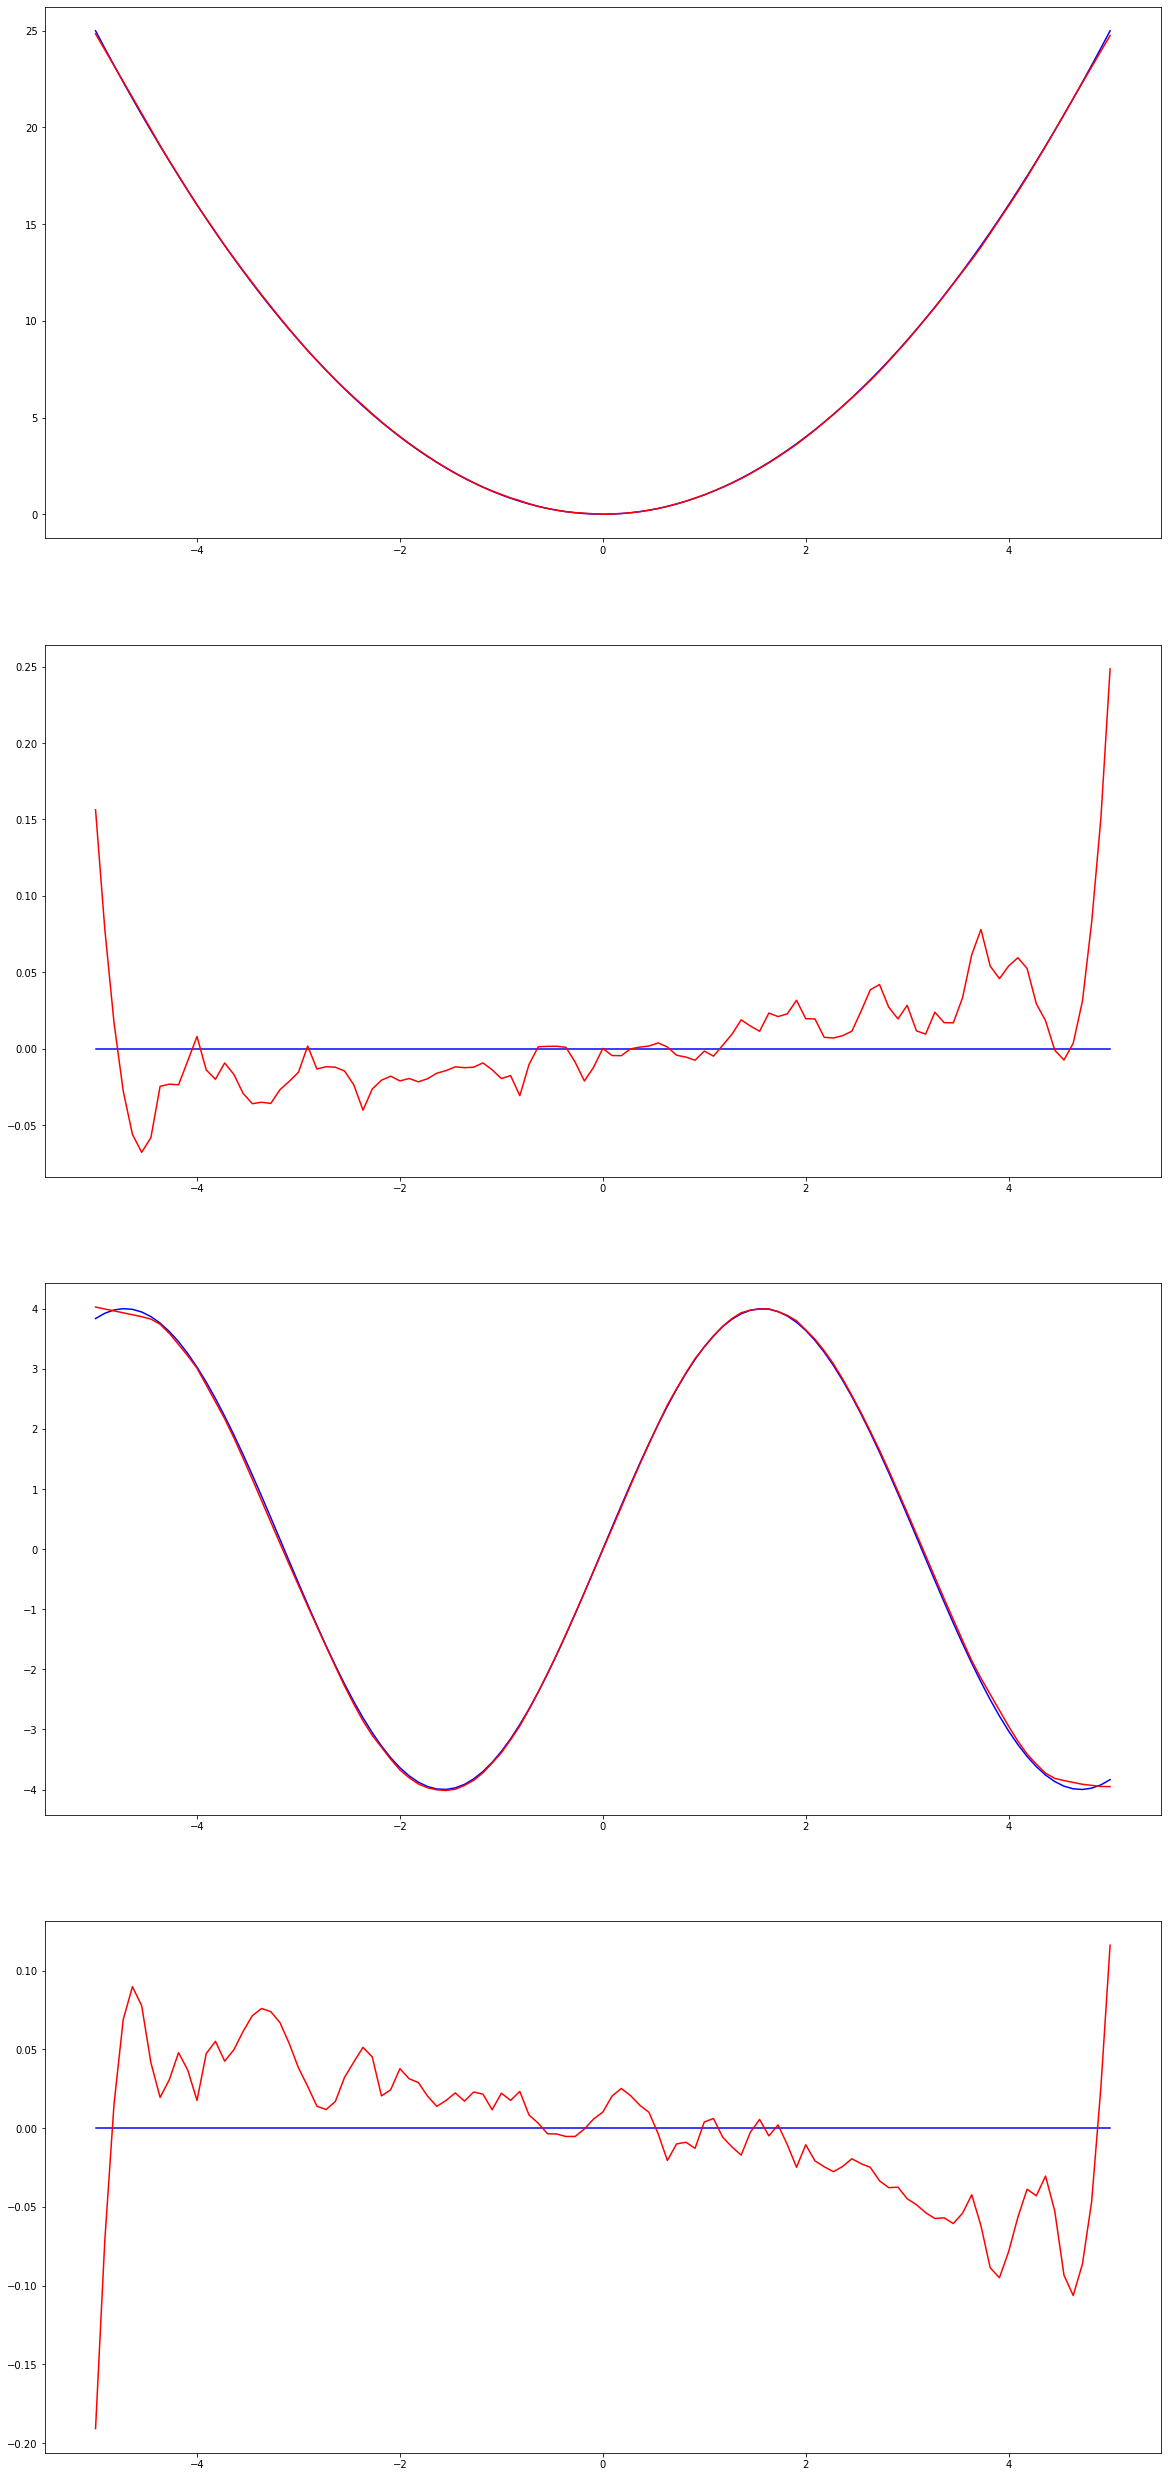

In [3]:
###############################################################################
# PyTorch examples - MSELoss (Mean Squared Error)
###############################################################################
import time
import numpy as np
from random import shuffle
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
#from torch.autograd import Variable

###############################################################################
use_cuda = torch.cuda.is_available()
use_cuda = False

###############################################################################
# hyperparameters
###############################################################################
nLinear1 = 100
nLinear2 = 100

#learning_rate = 0.0001
learning_rate = 0.001
#learning_rate = 0.01
#learning_rate = 0.1

# regularization (dropout, L2, batch size) -- lecture 4
dropout = 0.0
#dropout = 0.1

L2_lambda = 0.0
#L2_lambda = 0.1

#batch_size = 100
batch_size = 10
#batch_size = 1

# control amount of training data
nTrainPoints = 10
#nTrainPoints = 19
#nTrainPoints = 1009
nTrainPoints = 5003

nDevPoints = 101

nTestPoints = 111

#DesiredTrainSamples = 5000
DesiredTrainSamples = 50000

DisplayInterval = 5000

###############################################################################
class NN(nn.Module):
###############################################################################
    def __init__(self, input_size, nLinear1, nLinear2, output_size, dropout=0.0):
        super(NN, self).__init__()
        self.linear0 = nn.Linear(input_size, nLinear1)
        self.linear1 = nn.Linear(nLinear1, nLinear2)

        self.out0 = nn.Linear(nLinear2, 1)    # output for func0
        self.out1 = nn.Linear(nLinear2, 1)    # output for func1

        # all applicable non-linear functions from PyTorch with default parameters
        # pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity
        self.non_linear = nn.Softshrink(lambd=0.5)

        self.dropout = nn.Dropout(dropout)

        for p in self.parameters(): # optionally apply different randomization
            if p.dim() > 1:
                # all random initializations from PyTorch with default parameters
                nn.init.constant_(p, val=1.0)   # this is a really bad idea -- don't use it
                nn.init.orthogonal_(p, gain=1)
                nn.init.sparse_(p, sparsity=0.9, std=0.01)

                nn.init.uniform_(p, a=0.0, b=1.0)   # this works poorly, see next
                nn.init.uniform_(p, a=-1.0, b=1.0)  # default is a=0.0, b=1.0
                nn.init.normal_(p, mean=0.0, std=1.0)

                nn.init.kaiming_uniform_(p, a=0, mode='fan_in', nonlinearity='leaky_relu')
                nn.init.kaiming_normal_(p, a=0, mode='fan_in', nonlinearity='leaky_relu')

                nn.init.xavier_uniform_(p)
                nn.init.xavier_normal_(p)

    ###########################################################################
    def forward(self, inputs):
        nPoints = len(inputs)
        x = inputs.view(nPoints, -1)

        x = self.linear0(x)
        x = self.non_linear(x)
        x = self.dropout(x)

        x = self.linear1(x)
        x = self.non_linear(x)
        x = self.dropout(x)

        out0 = self.out0(x)  # func0
        out1 = self.out1(x)  # func1

        return out0, out1

###############################################################################
def train(model, optimizer, criteria, data, idx_list, update=True):
    model.zero_grad()

    nPoints = len(idx_list)
    inputs = []
    targets0 = []
    targets1 = []
    loss0 = 0
    loss1 = 0

    for i in idx_list:
        inputs.append(data[0][i])
        targets0.append(data[1][i])
        targets1.append(data[2][i])

    #inputs  = Variable(torch.Tensor(inputs))   # Variable is no longer needed
    inputs  = torch.Tensor(inputs)
    targets0 = torch.Tensor(targets0)
    targets1 = torch.Tensor(targets1)

    if use_cuda:
        inputs = inputs.cuda()
        targets0 = targets0.cuda()
        targets1 = targets1.cuda()

    output0, output1 = model(inputs)     # "model()" invokes "model.forward()"

    loss0 += criteria[0](output0.view(-1), targets0)
    loss1 += criteria[1](output1.view(-1), targets1)

    if update:
        loss = loss0 + loss1
        loss.backward()
        optimizer.step()

    return loss0.item(), loss1.item(), nPoints

###############################################################################
def train_model(model, train_data, dev_data):
    train_list  = [i for i in range(len(train_data[0]))]    # list of indexes of training data
    dev_list    = [i for i in range(len(dev_data[0]))]      # list of indexes of dev data
    
    criterion0 = nn.MSELoss(reduction='sum')
    criterion1 = nn.MSELoss(reduction='sum')
    criteria = [criterion0, criterion1]

    # choose an optimizer
    # all optimizers from PyTorch with default parameters, except learning_rate, and weight_decay
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=L2_lambda, amsgrad=False)

    ###############################################################################
    # train model 
    ###############################################################################
    start = time.time()

    nEpochs = ((DesiredTrainSamples - 1) // len(train_list)) + 1

    TrainLoss0 = 0
    TrainLoss1 = 0
    TrainPoints = 0
    TotalTrainSamples = 0
    nCurrentSamples = 0

    model.train()
    for epoch in range(nEpochs):
        shuffle(train_list)     # make it a habit to shuffle data, even if random
        #print(train_list)
        for i in range(0, len(train_list), batch_size):
            loss0, loss1, nPoints = train(model, optimizer, criteria, train_data, train_list[i:i+batch_size], update=True)
            #print(i, nTrainPairs, loss / nPoints)
            TrainLoss0 += loss0
            TrainLoss1 += loss1
            TrainPoints += nPoints
            TotalTrainSamples += nPoints
            nCurrentSamples += nPoints

            if (nCurrentSamples >= DisplayInterval) or (TotalTrainSamples >= DesiredTrainSamples):
                model.eval()
                DevLoss0, DevLoss1, DevPoints = train(model, optimizer, criteria, dev_data, dev_list, update=False)
                model.train()
                print("epoch = %5d %8d train = %8d\t%8.4f %8.4f\tdev = %8d\t%8.4f %8.4f" % (epoch, TotalTrainSamples, TrainPoints, TrainLoss0 / TrainPoints, TrainLoss1 / TrainPoints, DevPoints, DevLoss0 / DevPoints, DevLoss1 / DevPoints))

                TrainLoss0 = 0
                TrainLoss1 = 0
                TrainPoints = 0
                nCurrentSamples -= DisplayInterval

            if TotalTrainSamples >= DesiredTrainSamples:
                break

        if TotalTrainSamples >= DesiredTrainSamples:
            break

    torch.save(model, 'mse_02-temp.pth')

    return

###############################################################################
def func0(x):
    y = x*x
    return y

###############################################################################
def func1(x):
    #y = (x+1)*(x-2)
    y = 4*np.sin(x)
    return y

###############################################################################
def create_data(data_spec):
    x_lower, x_upper, nPoints = data_spec
    x = np.linspace(x_lower, x_upper, num=nPoints, endpoint=True).astype(np.float32)
    y0 = func0(x)
    y1 = func1(x)
    return [x, y0, y1]

###############################################################################
if __name__ == "__main__":
    start = time.time()

    ###############################################################################
    # create data
    ###############################################################################
    lower_bound = -5
    upper_bound = +5

    train_data  = create_data([lower_bound, upper_bound, nTrainPoints])
    dev_data    = create_data([lower_bound, upper_bound, nDevPoints])
    test_data   = create_data([lower_bound, upper_bound, nTestPoints])

    ###############################################################################
    # create model 
    ###############################################################################
    model = NN(1, nLinear1, nLinear2, 1, dropout)
    print(model)
    if use_cuda:
        model = model.cuda()

    train_model(model, train_data, dev_data)

    end = time.time()
    elapsed = end - start
    print("time = %.2f (sec)\n" % (elapsed))

    # let's see our neural network in action
    show_results = True
    #show_results = False
    if show_results:
        x, y0, y1 = test_data
        out0, out1 = model(torch.Tensor(x))
        #print(out0)
        out0 = out0.detach().cpu().numpy()[:,0] # remove output values from network, move to cpu, convert to numpy
        out1 = out1.detach().cpu().numpy()[:,0]
        #print(out0)
        #print(out0.shape)
        mse0 = (((y0 - out0)**2).sum()) / len(y0)
        print("mean squared error for test data =", mse0)

        nPlots = 4
        fig = plt.figure(figsize=(20,45))

        plt.subplot(nPlots,1,1)
        plt.plot(x, y0, 'b')
        plt.plot(x, out0, 'r')

        plt.subplot(nPlots,1,2)
        plt.plot(x, y0-y0, 'b')
        plt.plot(x, y0-out0, 'r')
        #plt.plot(train_data[0], train_data[1]-train_data[1], 'o')

        plt.subplot(nPlots,1,3)
        plt.plot(x, y1, 'b')
        plt.plot(x, out1, 'r')

        plt.subplot(nPlots,1,4)
        plt.plot(x, y1-y1, 'b')
        plt.plot(x, y1-out1, 'r')
        #plt.plot(train_data[0], train_data[2]-train_data[2], 'o')

        plt.show()


## 2)Gradient Descent (2%)
   f(x, y) = 3*(x^2 − y)^2 + 4*(y^2 − x)^2


### 1) What are the partial derivatives of f(x, y) with respect to x and y?

In [16]:
from sympy import Symbol, Derivative
x= Symbol('x')
y= Symbol('y')
function= 3*(x**2-y)**2 + 4*(y**2-x)**2
partialderiv_x= Derivative(function, x)
partialderiv_y= Derivative(function, y)
print("the partial derivative of f(x,y) to x is:")
partialderiv_x.doit()


the partial derivative of f(x,y) to x is:


12*x*(x**2 - y) + 8*x - 8*y**2

In [13]:
print("the partial derivative of f(x,y) to y is:")
partialderiv_y.doit()

the partial derivative of f(x,y) to y is:


-6*x**2 + 16*y*(-x + y**2) + 6*y

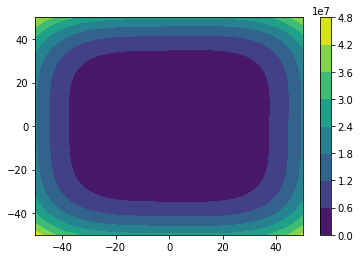

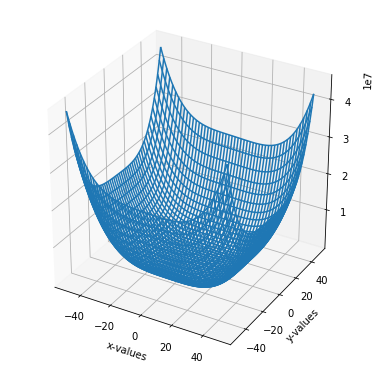

In [266]:
x = np.linspace(-50,50,300)
y = np.linspace(-50,50,300)
X, Y = np.meshgrid(x, y)
def function(x,y):
    return (3*(x**2-y)**2+4*(y**2-x)**2)
Z = function(X, Y)
c = plt.contourf(X, Y, Z)
plt.colorbar();


fig = plt.figure(figsize=(5,5),facecolor='w')
ax = Axes3D(fig)
a = ax.plot_wireframe(X, Y, Z)
plt.xlabel("x-values")
plt.ylabel("y-values")
plt.show()

### 2) Implement a gradient descent algorithm to find the minimum of this function.
• Test your code with various starting values; include (3, -12) and (300, -1200)
• What are some problems with the gradient descent algorithm?

the minimum of function f(x,y) is  0.00843572222721984


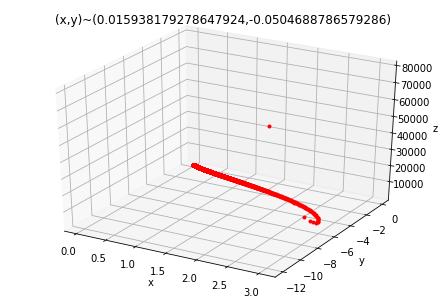

In [267]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
 
def Fun(x,y):
    return 3*(x**2-y)**2 + 4*(y**2-x)**2
 
def PxFun(x,y):
    return (12*x*(x**2-y)+8*x-8*y**2)
 
def PyFun(x,y):
    return (-6*x**2+16*y*(-x+y**2)+6*y)
 

fig=plt.figure()
ax=Axes3D(fig)
X,Y=np.mgrid[-2:2:40j,-2:2:40j]
Z=Fun(X,Y)
#ax.plot_surface(X,Y,Z,rstride=1,cstride=1,cmap="rainbow")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
 
#gradient descent
step=0.0001
x=3
y=-12
tag_x=[x]
tag_y=[y]
tag_z=[Fun(x,y)]
new_x=x
new_y=y
Over=False
while Over==False:
    new_x-=step*PxFun(x,y)
    new_y-=step*PyFun(x,y)
    if Fun(x,y)-Fun(new_x,new_y)<1e-5:
        Over=True
    x=new_x
    y=new_y#更新旧点
    tag_x.append(x)
    tag_y.append(y)
    tag_z.append(Fun(x,y))

print("the minimum of function f(x,y) is ",Fun(x,y))
ax.plot(tag_x,tag_y,tag_z,'r.')
plt.title('(x,y)~('+str(x)+","+str(y)+')')
plt.show()
#print(x,y)


the minimum of function f(x,y) is  0.010153765299146708


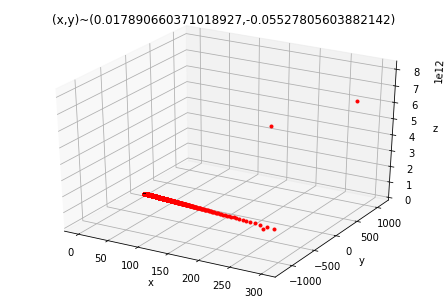

In [268]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
 
def Fun(x,y):
    return 3*(x**2-y)**2 + 4*(y**2-x)**2
 
def PxFun(x,y):
    return (12*x*(x**2-y)+8*x-8*y**2)
 
def PyFun(x,y):
    return (-6*x**2+16*y*(-x+y**2)+6*y)
 

fig=plt.figure()
ax=Axes3D(fig)
X,Y=np.mgrid[-2:2:40j,-2:2:40j]
Z=Fun(X,Y)
ax.plot_surface(X,Y,Z,rstride=1,cstride=1,cmap="rainbow")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
 
step=8.35e-8
x=300
y=-1200

tag_x=[x]
tag_y=[y]
tag_z=[Fun(x,y)]
new_x=x
new_y=y
Over=False
while Over==False:
    new_x-=step*PxFun(x,y)
    new_y-=step*PyFun(x,y)
    if Fun(x,y)-Fun(new_x,new_y)<1e-8:
        Over=True
    x=new_x
    y=new_y
    tag_x.append(x)
    tag_y.append(y)
    tag_z.append(Fun(x,y))

print("the minimum of function f(x,y) is ",Fun(x,y))
ax.plot(tag_x,tag_y,tag_z,'r.')
plt.title('(x,y)~('+str(x)+","+str(y)+')')
plt.show()

In [ ]:
"""
problems with gradient descent include choosing a proper learning rate so that we avoid slow convergence 
at small values, or divergence at larger values and applying the same learning rate 
to all parameter updates wherein if the data is sparse we might not want to update all of them to the same extent
"""

"""
Learning rate schedules [1] try to adjust the learning rate during training by e.g. annealing, 
i.e. reducing the learning rate according to a pre-defined schedule or when the change in objective 
between epochs falls below a threshold. These schedules and thresholds, however, have to be defined in advance 
and are thus unable to adapt to a dataset's characteristics.

Additionally, the same learning rate applies to all parameter updates. 
If our data is sparse and our features have very different frequencies,
we might not want to update all of them to the same extent, but perform a larger update for rarely occurring features.

Another key challenge of minimizing highly non-convex error functions common for neural networks is avoiding 
getting trapped in their numerous suboptimal local minima. Dauphin et al. 
 argue that the difficulty arises in fact not from local minima but from saddle points, 
i.e. points where one dimension slopes up and another slopes down. These saddle points are usually surrounded 
by a plateau of the same error, which makes it notoriously hard for SGD to escape, as the gradient is close to zero in all dimensions.
"""

### 3) Add at least one improvement to your algorithm which increases convergence or robustness

start point: [  3 -12]
min(x,y)= [-2.02181925e-08 -2.11197837e-08]
the minimum of function f(x,y) is  2.9732371387477558e-15


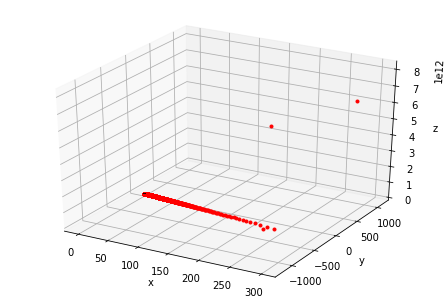

In [402]:
# using newton method
import numpy as np
import matplotlib.pyplot as plt
def banana(x):
    return(3*(x[0]**2-x[1])**2 + 4*(x[1]**2-x[0])**2)
    
#Gradient of banana function
def jacobian(x):
    return(np.array([(12*x[0]*(x[0]**2-x[1])+8*x[0]-8*x[1]**2),(-6*x[0]**2+16*x[1]*(-x[0]+x[1]**2)+6*x[1])]))

def hessian(x):
    return np.array([[(4*(9*x[0]**2-3*x[1]+2)),(-4*(3*x[0]+4*x[1]))],[(-4*(3*x[0]+4*x[1])),(-16*x[0]+48*x[1]**2+6)]])

fig=plt.figure()
ax=Axes3D(fig)
X,Y=np.mgrid[-2:2:40j,-2:2:40j]
Z=Fun(X,Y)
ax.plot_surface(X,Y,Z,rstride=1,cstride=1,cmap="rainbow")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

def newton(x0):
    #print('start point:')
    #print(x0,'\n')
    W=np.zeros((2,10**3))
    i = 1
    imax = 1000
    W[:,0] = x0 
    x = x0
    delta = 1
    alpha = 1

    while i<imax and delta>10**(-5):
        p = -np.dot(np.linalg.inv(hessian(x)),jacobian(x))
        x0 = x
        x = x + alpha*p
        W[:,i] = x
        delta = sum((x-x0)**2)
        #print('iteration',i,':')
        #print(x,'\n')
        i=i+1
    W=W[:,0:i]  
    return W

x0 = np.array([3,-12])
W = newton(x0)
print('start point:',x0)
print("min(x,y)=", W[:,-1])
data = np.array(W[:,-1])
print("the minimum of function f(x,y) is ",banana(data))
ax.plot(tag_x,tag_y,tag_z,'r.')
#plt.title('(x,y)~('+str(x)+","+str(y)+')')
plt.show()

#### Using the same start point , I found that using newton method has higher speed to converges and for the same # of iterations, the point it reaches in this problem is smaller than the gradient desecnt.

## 3) Build an XOR Neural Net using PyTorch (2%)


### (1)Create a network with:
### • 2 inputs
### • 1 output
### • any number of layers of any size you want
### • MSELoss as the loss function

In [403]:
import torch
import torch.nn as nn
import torch.nn.functional as F	
import torch.optim as optim	
from torchvision import datasets, transforms,utils
import os
import scipy.io as sio
import numpy as np
import torch.backends.cudnn as cudnn
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable


In [404]:
use_cuda = torch.cuda.is_available()
use_cuda = False

In [405]:
class Neuralnetwork(nn.Module):
    def __init__(self, input_dim=2, output_dim=1):
        super(Neuralnetwork, self).__init__()
        self.lin1 = nn.Linear(input_dim, 4)
        self.lin2 = nn.Linear(4, output_dim)

    def forward(self, x):
        x = self.lin1(x)
        x = torch.sigmoid(x)
        x = self.lin2(x)
        return x

def weights_init(model):
    for m in model.modules():
        if isinstance(m, nn.Linear):
            m.weight.data.normal_(-1, 1)
            

In [406]:
model = Neuralnetwork()
print(model)  # net architecture
weights_init(model)

Neuralnetwork(
  (lin1): Linear(in_features=2, out_features=4, bias=True)
  (lin2): Linear(in_features=4, out_features=1, bias=True)
)


In [407]:
 #Loss function 
criterion = nn.MSELoss(reduction='sum')

In [408]:
# training function
def train(model, learning_rate, criterion, data, idx_list):

    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    
    optimizer.zero_grad()

    nPoints = len(idx_list)
    inputs = []
    targets = []
    loss = 0

    for i in idx_list:
        inputs.append(data[0][i])
        targets.append(data[1][i])

    inputs = torch.Tensor(inputs)
    targets = torch.Tensor(targets)
    output = model(inputs)

    loss += criterion(output.view(-1), targets)

    loss.backward()
    optimizer.step()

    return loss.item(), nPoints

### 2) Generate your own XOR datasets – train, dev, and test. Use random values of x and y between -1 and +1

In [409]:
# a function that creates data 
def create_data(npoints):
    #random.seed(1)
    x = []
    y = []
    for i in range(npoints):
        x0 = random.randint(-1, 1)
        x1 = random.randint(-1, 1)
        label = 0 if x0 * x1 > 0 else 1
        x.append([x0, x1])
        y.append(label)
    x = np.asarray(x)
    y = np.asarray(y)

    return [x, y]

In [410]:
datapoints = 1000
train_data = create_data(int(0.8*datapoints))
dev_data = create_data(int(0.1*datapoints))
test_data = create_data(int(0.1*datapoints))

In [411]:
DataPoints = len(train_data[0])
train_list = [i for i in range(len(train_data[0]))]           
dev_list = [i for i in range(len(dev_data[0]))]   
test_list = [i for i in range(len(test_data[0]))]

### 3)Train and tune the neural net with your XOR train dataset

In [412]:
batchSize = 10
nEpochs = 100 
learning_rate = 0.001

In [413]:
# train XOR model
for epoch in range(nEpochs):
    random.shuffle(train_list)
    TrainLoss = 0
    TrainPoints = 0
    
    for i in range(0, DataPoints, batch_size):
        loss, nPoints = train(model, learning_rate, criterion, train_data, train_list[i:i+batch_size])
        TrainLoss += loss
        TrainPoints += nPoints
    
    if epoch % (nEpochs/10) == 0:
        print(f'Epoch: {epoch}, Loss: {TrainLoss/TrainPoints:.6f}')

Epoch: 0, Loss: 2.287799
Epoch: 10, Loss: 0.129972
Epoch: 20, Loss: 0.084600
Epoch: 30, Loss: 0.051579
Epoch: 40, Loss: 0.036364
Epoch: 50, Loss: 0.030343
Epoch: 60, Loss: 0.027656
Epoch: 70, Loss: 0.026066
Epoch: 80, Loss: 0.024999
Epoch: 90, Loss: 0.024088


In [414]:
#tune XOR model
nEpochslist = []
lrlist = []
combine = []
m = 500
n = 10
for i in range(1,4,1):
    nEpochslist.append(500*i)
    lrlist.append(n**(-i))

combine =  [(epoch, lr) for epoch in nEpochslist for lr in lrlist]
combine

[(500, 0.1),
 (500, 0.01),
 (500, 0.001),
 (1000, 0.1),
 (1000, 0.01),
 (1000, 0.001),
 (1500, 0.1),
 (1500, 0.01),
 (1500, 0.001)]

In [392]:
import numpy as np
import matplotlib.pyplot as plt
for c in range(len(combine)):
    
    model=XOR()
    weights_init(model)
    
    nEpochs = combine[c][0]
    learning_rate = combine[c][1]
    print(f'Number of epochs: {nEpochs}, Learning rate: {learning_rate}')
    for epoch in range(nEpochs):
        random.shuffle(dev_list)
        TrainLoss = 0
        TrainPoints = 0
    
        for i in range(0, len(dev_list), batch_size):
            loss, nPoints = train(model, learning_rate, criterion, dev_data, dev_list[i:i+batch_size])
            TrainLoss += loss
            TrainPoints += nPoints
        if epoch % (nEpochs/10) == 0:
            print(f'Epoch: {epoch}, Loss: {TrainLoss/TrainPoints:.6f}')


Number of epochs: 500, Learning rate: 0.1
Epoch: 0, Loss: 261.537375
Epoch: 50, Loss: 57.507330
Epoch: 100, Loss: 520.100913
Epoch: 150, Loss: 222.314102
Epoch: 200, Loss: 333.885330
Epoch: 250, Loss: 233.637830
Epoch: 300, Loss: 154.868633
Epoch: 350, Loss: 395.410964
Epoch: 400, Loss: 408.251638
Epoch: 450, Loss: 352.262178
Number of epochs: 500, Learning rate: 0.01
Epoch: 0, Loss: 1.938262
Epoch: 50, Loss: 0.101359
Epoch: 100, Loss: 0.034653
Epoch: 150, Loss: 0.024064
Epoch: 200, Loss: 0.020706
Epoch: 250, Loss: 0.017698
Epoch: 300, Loss: 0.017010
Epoch: 350, Loss: 0.015275
Epoch: 400, Loss: 0.013763
Epoch: 450, Loss: 0.012784
Number of epochs: 500, Learning rate: 0.001
Epoch: 0, Loss: 3.991723
Epoch: 50, Loss: 0.193854
Epoch: 100, Loss: 0.185889
Epoch: 150, Loss: 0.179660
Epoch: 200, Loss: 0.172638
Epoch: 250, Loss: 0.165067
Epoch: 300, Loss: 0.155244
Epoch: 350, Loss: 0.144525
Epoch: 400, Loss: 0.132109
Epoch: 450, Loss: 0.118442
Number of epochs: 1000, Learning rate: 0.1
Epoch: 0

#### To choose the model, use the pochs: 1500, Learning rate: 0.01 since it has the smallest loss which is 0.004196

### 4) Evaluate the neural net with your XOR test dataset. 

In [415]:
nEpochs = 1500
batch_size = 10
learning_rate = 0.01

model = Neuralnetwork()
#print(model)  # net architecture
weights_init(model)
    
for epoch in range(nEpochs):
    random.shuffle(dev_list)
    TrainLoss = 0
    TrainPoints = 0
    
    for i in range(0, len(dev_list), batch_size):
        loss, nPoints = train(model, learning_rate, criterion, dev_data, dev_list[i:i+batch_size])
        TrainLoss += loss
        TrainPoints += nPoints
    
    if epoch % (nEpochs/10) == 0:
        print(f'Epoch: {epoch}, Loss: {TrainLoss/TrainPoints:.6f}')

Epoch: 0, Loss: 1.848502
Epoch: 150, Loss: 0.025688
Epoch: 300, Loss: 0.014824
Epoch: 450, Loss: 0.008090
Epoch: 600, Loss: 0.003399
Epoch: 750, Loss: 0.001223
Epoch: 900, Loss: 0.000454
Epoch: 1050, Loss: 0.000125
Epoch: 1200, Loss: 0.000037
Epoch: 1350, Loss: 0.000011


In [394]:
#calculate the testdata's mse
x, y = test_data
out = model(torch.Tensor(x))
out = out.detach().cpu().numpy()[:,0]
mse = (((y - out)**2).sum()) / len(y)
mse

0.004941253983454317

#### According the mse result and the convergence's speed, I think this neuro nets trains well. 